# City Recommendation System

##### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from geopy.geocoders import Nominatim
from ipywidgets import HTML
from ipyleaflet import Map, Marker
from handle_data import *

geolocator = Nominatim(user_agent="myGeolocator")

##### Import Data

In [3]:
# Load the ranking and business environment data
city_df = pd.read_csv("data/Best Cities for Startups.csv")
country_df = pd.read_csv("data/Best Countries for Startups.csv")

# Load the location data
city_location_df = pd.read_csv("data/city_locations.csv")
country_location_df = pd.read_csv("data/country_locations.csv")

##### Convert Data to Pivot Table

In [4]:
# country pivot
country_locations_pivot = pd.pivot_table(country_location_df, index=["country"], values=["latitude", "longitude"])

##### Convert City Location and Country Data to Dictionary

In [5]:
city_location_dict = city_location_df.set_index("city").T.to_dict('list')
country_data_dict = country_df.set_index("country").T.to_dict('list')

##### Fit data to model

In [6]:
country_recommendation_model = NearestNeighbors(metric='euclidean', algorithm='brute')
country_recommendation_model.fit(country_locations_pivot)

NearestNeighbors(algorithm='brute', metric='euclidean')

##### Get Logitude and Latitude of Current City

In this case, Roma's current city is **Reston, VA**.

In [7]:
city_geo_location = geolocator.geocode("Reston, VA")

city_location = city_geo_location.latitude, city_geo_location.longitude

home_country = city_geo_location.address.split(',')[3].strip()

##### Get Recommendations
Our model will return 10 countries that are closest to the current city. 

In [8]:
recommended_countries = country_recommendation_model.kneighbors([city_location], n_neighbors=10)

##### Gather recommendations from the model

In [9]:
list_of_countries = []

for i in range(0, len(recommended_countries[0].flatten())):
    list_of_countries.append(country_locations_pivot.index[recommended_countries[1].flatten()[i]])

##### Gather list of cities from the countries

In [10]:
list_of_cities = []

for i in list_of_countries:
    working_list = get_list_of_cities(i, home_country, city_df)

    if working_list is not None:
        list_of_cities.extend(working_list)

##### Get list of top 3 cities

In [11]:
top_recommendations = get_best_list_of_cities(list_of_cities)

print("Top Recommendations:")
for i in top_recommendations:
    print(i[1] + "," + i[2])

Top Recommendations:
Toronto, Canada
Vancouver, Canada
Montreal, Canada


##### Get the location of the top 3 cities

In [12]:
city1 = city_location_dict[top_recommendations[0][1]]
city2 = city_location_dict[top_recommendations[1][1]]
city3 = city_location_dict[top_recommendations[2][1]]

##### Interactive Map

In [13]:
m = Map(center=[city_geo_location.latitude, city_geo_location.longitude], zoom=3)

# create the markers
city1_marker = Marker(location=[city1[0], city1[1]])
city2_marker = Marker(location=[city2[0], city2[1]])
city3_marker = Marker(location=[city3[0], city3[1]])

# create the popup messages
message1 = HTML()
message2 = HTML()
message3 = HTML()

message1.value = str(top_recommendations[0][0]) + ": " + str(top_recommendations[0][1]) + ", " + str(top_recommendations[0][2]) + " <br> Total Score: " + str(top_recommendations[0][3])
message2.value = str(top_recommendations[1][0]) + ": " + str(top_recommendations[1][1]) + ", " + str(top_recommendations[1][2]) + " <br> Total Score: " + str(top_recommendations[1][3])
message3.value = str(top_recommendations[2][0]) + ": " + str(top_recommendations[2][1]) + ", " + str(top_recommendations[2][2]) + " <br> Total Score: " + str(top_recommendations[2][3])

# create the popups 
city1_marker.popup = message1
city2_marker.popup = message2
city3_marker.popup = message3

# add the markers to the map
m.add_layer(city1_marker)
m.add_layer(city2_marker)
m.add_layer(city3_marker)

m

Map(center=[38.955696, -77.34188283719988], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_i…

##### Top 3 Cities in Detail

In [14]:
top_cities_df = pd.DataFrame(top_recommendations, columns=["position", "city", "country", "total score", "quantity score", "quality score", "business score"])

top_cities_df.style

,position,city,country,total score,quantity score,quality score,business score
0,26,Toronto,Canada,15.678000,4.640000,7.490000,3.550000
1,42,Vancouver,Canada,10.350000,2.390000,4.410000,3.550000
2,46,Montreal,Canada,9.248000,1.790000,3.910000,3.550000


##### Top 3 Cities Total Score in Comparison

<AxesSubplot:xlabel='city'>

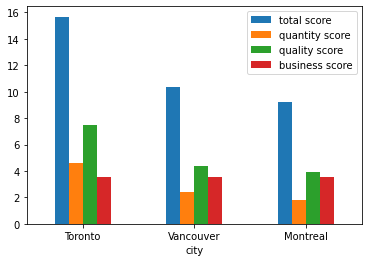

In [15]:
top_cities_df.plot.bar(x="city", y=["total score", "quantity score", "quality score", "business score" ], rot=0)

##### Home country vs Selected Country and Mexico

In [16]:
us_data = country_df[country_df["country"] == "United States"]
canada_data = country_df[country_df["country"] == "Canada"]
mexico_data = country_df[country_df["country"] == "Mexico"]
comparison_data = pd.concat([us_data, canada_data, mexico_data])


import plotly.express as px

fig = px.bar(comparison_data, x="country", y=["total score", "quantity score", "quality score", "business score"], barmode="group")

fig